In [1]:
import sys

- 电脑重装问题

In [48]:
sys.path

['',
 'F:\\AI比赛\\DataWhle',
 'E:\\anaconda_install\\python37.zip',
 'E:\\anaconda_install\\DLLs',
 'E:\\anaconda_install\\lib',
 'E:\\anaconda_install',
 'E:\\anaconda_install\\lib\\site-packages',
 'E:\\anaconda_install\\lib\\site-packages\\win32',
 'E:\\anaconda_install\\lib\\site-packages\\win32\\lib',
 'E:\\anaconda_install\\lib\\site-packages\\Pythonwin',
 'E:\\anaconda_install\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\mzy\\.ipython',
 'E:\\anaconda_install\\envs\\AI',
 'E:\\anaconda_install\\envs\\AI\\Lib\\site-packages']

- 重新安装之后需要添加路径

In [53]:
sys.path.append("E:\\anaconda_install\\envs\\AI")
sys.path.append("E:\\anaconda_install\\envs\\AI\\Lib\\site-packages")
sys.path.append("E:\\anaconda_install\\xgboost\\xgboost.dll")
sys.path.append("E:\\anaconda_install\\envs\\AI\\Lib\\site-packages\\xgboost")

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import lightgbm as lgb

In [6]:
pd.set_option('display.max_columns', None)

In [7]:
train_data = pd.read_csv("./train_data.csv")
test_data = pd.read_csv("./test_a.csv")

In [8]:
train_data = train_data.drop(["ID","city"],axis = 1)
test_data = test_data.drop(["ID","city"],axis = 1)

In [9]:
for df in [train_data,test_data]:
    df['rentType'][df['rentType']=='--'] = '未知方式'
    # 转换object类型数据
    columns = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'communityName', 'region', 'plate']
    for col in columns:
        df[col] = df[col].astype('category')

In [10]:
for df in [train_data,test_data]:
    tmp = df['buildYear'].copy()
    tmp2 = tmp[tmp!='暂无信息'].astype('int')
    tmp[tmp=='暂无信息'] = tmp2.mode().iloc[0]
    df['buildYear'] = tmp
    df['buildYear'] = df['buildYear'].astype('int')
    
    df['pv'].fillna(df['pv'].mean(),inplace=True)
    df['uv'].fillna(df['uv'].mean(),inplace=True)
    df['pv'] = df['pv'].astype('int')
    df['uv'] = df['uv'].astype('int')
    df.drop('communityName',axis=1, inplace=True)

In [11]:
for df in [train_data,test_data]:
    # 将houseType转化为‘房间数’，‘厅数’，‘卫生间数’
    def parseRoom(info, index):
        res = int(info[index*2])
        return res
    df.insert(3,'室',None)
    df.insert(4, '厅', None)
    df.insert(5, '卫', None)
    df['室'] = df['houseType'].apply(parseRoom, index=0)
    df['厅'] = df['houseType'].apply(parseRoom, index=1)
    df['卫'] = df['houseType'].apply(parseRoom, index=2)
    
    df['交易月份'] = df['tradeTime'].apply(lambda x: int(x.split('/')[1]))
#     df['pv/uv'] = df['pv'] / df['uv']
#     df['房间总数'] = df['室'] + df['厅'] + df['卫']
    
    df.drop('houseType', axis=1, inplace=True)
    df.drop('tradeTime', axis=1, inplace=True)

### 简单数据清洗

In [12]:
train_data = train_data[train_data['area']<=700]
train_data = train_data[train_data['tradeMoney']<=100000]

### new1 删除离群点

In [13]:
train_data = train_data[train_data["area"]<400]
train_data = train_data[(train_data["area"]<400)&(train_data["tradeMoney"]<60000)]
train_data = train_data.drop(train_data[(train_data['area']<130)&(train_data["tradeMoney"]>40000)].index)
train_data = train_data.drop(train_data[(train_data['area']>350)&(train_data["tradeMoney"]<5000)].index)
train_data = train_data.drop(train_data[train_data["tradeMoney"]<1].index)
train_data = train_data.drop(train_data[train_data["area"]<10].index)

### new2 删除test中没有的值

In [14]:
train_data = train_data.drop(train_data[train_data['室']==0].index)
train_data = train_data.drop(train_data[train_data['室']==7].index)
train_data = train_data.drop(train_data[train_data['室']==8].index)
train_data = train_data.drop(train_data[train_data['室']==9].index)

train_data = train_data.drop(train_data[train_data['厅']==4].index)
train_data = train_data.drop(train_data[train_data['厅']==5].index)

train_data = train_data.drop(train_data[train_data['卫']==8].index)
train_data = train_data.drop(train_data[train_data['卫']==7].index)
train_data = train_data.drop(train_data[train_data['卫']==5].index)

### new3 删除test中没有的值

In [15]:
train_data = train_data.drop(train_data[train_data['region']=="RG00015"].index)

### new4 删除test中没有的值

In [16]:
trian_data = train_data.drop(train_data[(train_data["plate"] == "BK00058")|(train_data["plate"] == "BK00032")].index)

### 特征工程

In [17]:
trian_data.head()

,area,rentType,室,厅,卫,houseFloor,totalFloor,houseToward,houseDecoration,region,plate,buildYear,saleSecHouseNum,subwayStationNum,busStationNum,interSchoolNum,schoolNum,privateSchoolNum,hospitalNum,drugStoreNum,gymNum,bankNum,shopNum,parkNum,mallNum,superMarketNum,totalTradeMoney,totalTradeArea,tradeMeanPrice,tradeSecNum,totalNewTradeMoney,totalNewTradeArea,tradeNewMeanPrice,tradeNewNum,remainNewNum,supplyNewNum,supplyLandNum,supplyLandArea,tradeLandNum,tradeLandArea,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeMoney,交易月份
0,68.06,未知方式,2,1,1,低,16,暂无数据,其他,RG00001,BK00064,1953,0,7,36,0,28,1,1,12,15,16,76,5,3,22,355584000,7411.98,47974.22551,111,810967373,7755,104573.48460,25,264,0,0,0.0,0,0.0,0,0.0000,28248,614,111546,1124,284,0,2000.0,11
1,125.55,未知方式,3,2,2,中,14,暂无数据,简装,RG00002,BK00049,2007,0,2,184,0,26,0,1,27,5,16,163,6,4,51,5000000,122.83,40706.66775,2,9668955,286,33807.53497,2,4,0,0,0.0,0,0.0,0,0.0000,14823,148,157552,701,22,1,2000.0,12
2,132.00,未知方式,3,2,2,低,32,暂无数据,其他,RG00002,BK00050,1994,3,6,60,1,43,2,3,24,35,37,85,6,4,30,1687284798,49071.30,34384.35089,555,344894466,3143,109734.16040,11,159,126,0,0.0,0,0.0,0,0.0000,77645,520,131744,57,20,1,16000.0,12
3,57.00,未知方式,1,1,1,中,17,暂无数据,精装,RG00002,BK00051,1994,0,3,364,2,60,1,8,83,30,47,358,3,1,131,468272888,22809.70,20529.55050,260,196307819,6418,30587.07058,58,730,0,1,108037.8,1,108037.8,332760000,3080.0331,8750,1665,253337,888,279,9,1600.0,12
4,129.00,未知方式,3,2,3,低,2,暂无数据,毛坯,RG00003,BK00044,1994,1,0,141,0,15,0,0,21,5,10,100,5,2,34,108851470,4463.62,24386.36577,38,286722058,5608,51127.32846,34,851,216,0,0.0,0,0.0,0,0.0000,800,117,125309,2038,480,0,2900.0,11


- 房间总数

In [18]:
train_data["HomeNum"] = train_data["室"] + train_data["卫"] + train_data["厅"]

In [19]:
train_data["HomeNum"].isnull().sum()

0

In [20]:
train_data["室"].isnull().sum()

0

In [21]:
train_data["卫"].isnull().sum()

0

In [22]:
train_data["厅"].isnull().sum()

0

- 成交均价

In [23]:
trian_data["tradeMean"] = train_data["totalTradeMoney"]/train_data["totalTradeArea"]
trian_data["tradeNewMean"] = train_data["totalNewTradeMoney"]/train_data["totalNewTradeArea"]
trian_data["landMean"] = train_data["landTotalPrice"]/train_data["tradeLandArea"]

- 总数量

In [24]:
trian_data["bus"] = train_data["subwayStationNum"] + train_data["busStationNum"]

In [25]:
train_data["school"]  = train_data["interSchoolNum"]+train_data["schoolNum"]+train_data["privateSchoolNum"]

In [26]:
trian_data["docter"] = train_data["hospitalNum"] + train_data["drugStoreNum"]

In [27]:
trian_data["shop"] = train_data["shopNum"] + train_data["superMarketNum"]+ train_data["mallNum"]

In [28]:
trian_data["sport"] = train_data["gymNum"] + train_data["parkNum"]

- test

In [29]:
test_data["HomeNum"] = test_data["室"] + test_data["卫"] + test_data["厅"]

test_data["tradeMean"] = test_data["totalTradeMoney"]/test_data["totalTradeArea"]
test_data["tradeNewMean"] = test_data["totalNewTradeMoney"]/test_data["totalNewTradeArea"]
test_data["landMean"] = test_data["landTotalPrice"]/test_data["tradeLandArea"]

test_data["bus"] = test_data["subwayStationNum"] + test_data["busStationNum"]
test_data["school"]  = test_data["interSchoolNum"]+test_data["schoolNum"]+test_data["privateSchoolNum"]
test_data["docter"] = test_data["hospitalNum"] + test_data["drugStoreNum"]
test_data["shop"] = test_data["shopNum"] + test_data["superMarketNum"]+ test_data["mallNum"]
test_data["sport"] = test_data["gymNum"] + test_data["parkNum"]

In [30]:
# train_data["tradeMoney"] = np.log1p(train_data["tradeMoney"])

In [31]:
train_data.head()

,area,rentType,室,厅,卫,houseFloor,totalFloor,houseToward,houseDecoration,region,plate,buildYear,saleSecHouseNum,subwayStationNum,busStationNum,interSchoolNum,schoolNum,privateSchoolNum,hospitalNum,drugStoreNum,gymNum,bankNum,shopNum,parkNum,mallNum,superMarketNum,totalTradeMoney,totalTradeArea,tradeMeanPrice,tradeSecNum,totalNewTradeMoney,totalNewTradeArea,tradeNewMeanPrice,tradeNewNum,remainNewNum,supplyNewNum,supplyLandNum,supplyLandArea,tradeLandNum,tradeLandArea,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeMoney,交易月份,HomeNum,school
0,68.06,未知方式,2,1,1,低,16,暂无数据,其他,RG00001,BK00064,1953,0,7,36,0,28,1,1,12,15,16,76,5,3,22,355584000,7411.98,47974.22551,111,810967373,7755,104573.48460,25,264,0,0,0.0,0,0.0,0,0.0000,28248,614,111546,1124,284,0,2000.0,11,4,29
1,125.55,未知方式,3,2,2,中,14,暂无数据,简装,RG00002,BK00049,2007,0,2,184,0,26,0,1,27,5,16,163,6,4,51,5000000,122.83,40706.66775,2,9668955,286,33807.53497,2,4,0,0,0.0,0,0.0,0,0.0000,14823,148,157552,701,22,1,2000.0,12,7,26
2,132.00,未知方式,3,2,2,低,32,暂无数据,其他,RG00002,BK00050,1994,3,6,60,1,43,2,3,24,35,37,85,6,4,30,1687284798,49071.30,34384.35089,555,344894466,3143,109734.16040,11,159,126,0,0.0,0,0.0,0,0.0000,77645,520,131744,57,20,1,16000.0,12,7,46
3,57.00,未知方式,1,1,1,中,17,暂无数据,精装,RG00002,BK00051,1994,0,3,364,2,60,1,8,83,30,47,358,3,1,131,468272888,22809.70,20529.55050,260,196307819,6418,30587.07058,58,730,0,1,108037.8,1,108037.8,332760000,3080.0331,8750,1665,253337,888,279,9,1600.0,12,3,63
4,129.00,未知方式,3,2,3,低,2,暂无数据,毛坯,RG00003,BK00044,1994,1,0,141,0,15,0,0,21,5,10,100,5,2,34,108851470,4463.62,24386.36577,38,286722058,5608,51127.32846,34,851,216,0,0.0,0,0.0,0,0.0000,800,117,125309,2038,480,0,2900.0,11,8,15


In [32]:
train_data.shape

(40142, 52)

In [33]:
columns = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'region', 'plate']
for col in columns:
    train_data[col] = train_data[col].astype('category')
    test_data[col] = test_data[col].astype('category')

In [34]:
for col in train_data.columns:
    if train_data[col].dtype.name == "category":
        print(col)


rentType
houseFloor
houseToward
houseDecoration
region
plate


### 需要的数据
- train
- target
- test
- features
- categorical_feats

### lightgbm

In [35]:
train = train_data.drop(["tradeMoney"],axis = 1)
target = train_data["tradeMoney"]

In [36]:
test = test_data

In [37]:
features = train.columns

In [38]:
categorical_feats = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'region', 'plate']

In [39]:
params = {
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'min_child_samples':20,
    'objective': 'regression',
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "feature_fraction": 0.8,
    "bagging_freq": 1,
    "bagging_fraction": 0.85,
    "bagging_seed": 23,
    "metric": 'rmse',
    "lambda_l1": 0.2,
    "nthread": 4,
}

In [40]:
folds = KFold(n_splits=5, shuffle=True, random_state=2333)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx])# categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 200)
    
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_lgb += clf.predict(test, num_iteration=clf.best_iteration) / folds.n_splits
    
print("CV Score: {:<8.5f}".format(r2_score(target, oof_lgb)))

fold 0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1168.69	valid_1's rmse: 1254.96
[1000]	training's rmse: 1019.85	valid_1's rmse: 1207.57
[1500]	training's rmse: 931.986	valid_1's rmse: 1187.47
[2000]	training's rmse: 867.876	valid_1's rmse: 1174.88
[2500]	training's rmse: 818.417	valid_1's rmse: 1167.8
[3000]	training's rmse: 778.598	valid_1's rmse: 1162.95
[3500]	training's rmse: 744.37	valid_1's rmse: 1158.75
[4000]	training's rmse: 715.447	valid_1's rmse: 1156.42
[4500]	training's rmse: 690.009	valid_1's rmse: 1155.07
Early stopping, best iteration is:
[4533]	training's rmse: 688.419	valid_1's rmse: 1154.95
fold 1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1174.5	valid_1's rmse: 1287.39
[1000]	training's rmse: 1032.19	valid_1's rmse: 1237.88
[1500]	training's rmse: 945.807	valid_1's rmse: 1213.27
[2000]	training's rmse: 882.496	valid_1's rmse: 1200.1
[2500]	training's rmse: 834.105	valid_1's rmse:

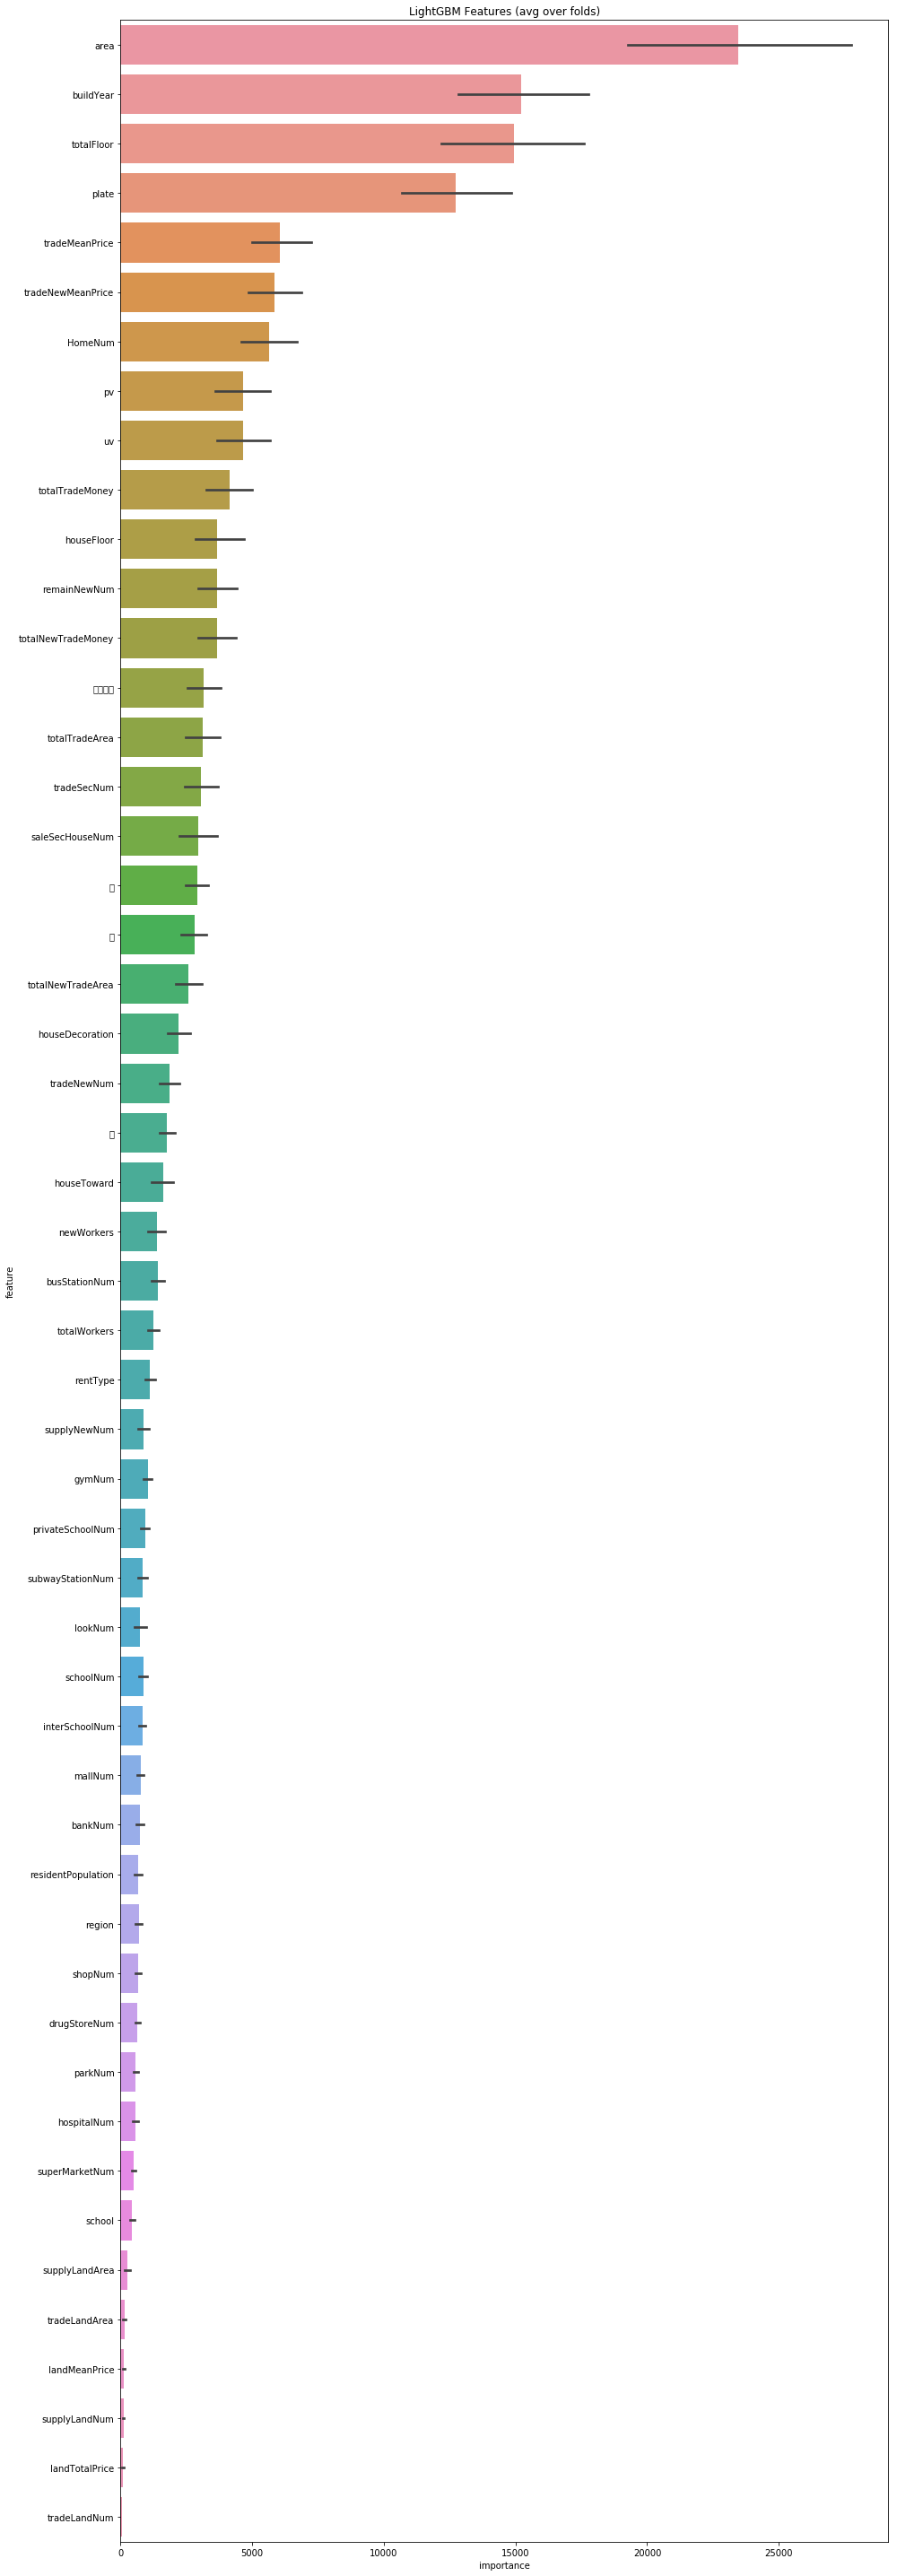

In [41]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,40))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [42]:
from sklearn.metrics import r2_score
def online_score(pred):
    print("预测结果最大值：{},预测结果最小值：{}".format(pred.max(),pred.min()))
    # a榜测分
    conmbine1 = pd.read_csv("./label.csv",engine = "python")#,header=None)
    score1 = r2_score(pred, conmbine1)
    print(score1)
    return score1
#     # b榜测分
#     conmbine3 = pd.read_csv("D:/城市-房产租金预测/best_result/sub_b_9194.csv",engine = "python",header=None)
#     score3= r2_score(pred, conmbine3)
#     print("对比919分数:{}".format(score3))

In [43]:
# predictions_lgb = np.expm1(predictions_lgb)

In [44]:
online_score(predictions_lgb)

预测结果最大值：18181.473394218847,预测结果最小值：1179.6343209811814
0.9442224332866131


0.9442224332866131

### xgboost

In [54]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(
 learning_rate =0.05,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=2,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=3,
 seed=2019)

XGBoostLibraryNotFound: Cannot find XGBoost Library in the candidate path, did you install compilers and run build.sh in root path?
List of candidates:
E:\anaconda_install\envs\AI\Lib\site-packages\xgboost\xgboost.dll
E:\anaconda_install\envs\AI\Lib\site-packages\xgboost\../../lib/xgboost.dll
E:\anaconda_install\envs\AI\Lib\site-packages\xgboost\./lib/xgboost.dll
E:\anaconda_install\xgboost\xgboost.dll
E:\anaconda_install\envs\AI\Lib\site-packages\xgboost\../../windows/x64/Release/xgboost.dll
E:\anaconda_install\envs\AI\Lib\site-packages\xgboost\./windows/x64/Release/xgboost.dll

In [ ]:
xgb_model.fit(x_train,y_train)
xgb_model.score(x_test,y_test)

- 随机森林

In [56]:
from sklearn.tree import DecisionTreeClassifier
DTC_model = DecisionTreeClassifier()
DTC_model.fit(train,target)

ValueError: could not convert string to float: 'BK00020'

- catboost

In [ ]:
import catboost as cat
ctb_params = {

    'iterations': 700,
    'learning_rate': 0.02,
    'depth': 12,
    'eval_metric': 'RMSE',
    'random_seed' : 23,
    'bagging_temperature': 0.2,
    'od_type': 'Iter',
    'metric_period':  75,
    'od_wait': 100
    }

folds = KFold(n_splits=5, shuffle=True, random_state=2333)

oof_cat = np.zeros(len(train))
predictions_cat = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_))
#     trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx])
#     val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx])
#     trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
#     val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx], categorical_feature=categorical_feats)

#     num_round = 10000
    clf = cat.CatBoostRegressor(**ctb_params)
    clf.fit(train.iloc[trn_idx], target.iloc[trn_idx], early_stopping_rounds=200, verbose_eval=3000,
                use_best_model=True,eval_set=(train.iloc[val_idx], target.iloc[val_idx]))
    oof_cat[val_idx] = clf.predict(train.iloc[val_idx])
    predictions_cat += clf.predict(test) / folds.n_splits
    predictions_cat += clf.predict(test, num_iteration=clf.best_iteration) / folds.n_splits
    
print("CV Score: {:<8.5f}".format(r2_score(target, oof_cat)))

- hyperopt

In [ ]:
# https://www.jianshu.com/p/35eed1567463

- Gridsearch

In [ ]:
cv_params = {'n_estimators': [20,40,60]}
other_params = {'random_state': 2019}

model =  RandomForestClassifier(**other_params)
optimized_rf = GridSearchCV(estimator=model, param_grid = cv_params,scoring ='roc_auc', cv=5)
optimized_rf.fit(x_train, y_train)
evalute_result = optimized_rf.cv_results_
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(optimized_rf.best_params_))
print('最佳模型得分:{0}'.format(optimized_rf.best_score_))
print("test结果",optimized_rf.score(x_test, y_test))

In [ ]:
8月2日 下午补充

## 总结